# Assignment 3: Use a single feature with different models

### Load full SVHN from HugginFace

In [1]:
# Import hugging face dataset
import huggingface_hub
from datasets import load_dataset

# Import cropped-digits dataset
dataset_cropped_digits_raw = load_dataset("ufldl-stanford/svhn", "cropped_digits")

extra-00001-of-00002.parquet:  31%|###       | 157M/512M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/73257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/26032 [00:00<?, ? examples/s]

Generating extra split:   0%|          | 0/531131 [00:00<?, ? examples/s]

### Common functions

In [2]:
import numpy
import matplotlib.pyplot as plotter
from PIL import Image

def get_errors(y, y_predict):
    mse = numpy.mean((y - y_predict)**2)
    rmse = numpy.sqrt(mse)
    mae = numpy.mean(numpy.abs(y - y_predict))

    print(f'MSE:{mse} RMSE:{rmse} MAE:{mae}')

    return mse, rmse, mae

def get_labels_and_pixel_arrays(ds : object):
    # Need to extract only the data we care about in numpy arrays
    labels = []
    first_pixel_red_values = []
    ds_sample_size = len(ds)

    for sample in ds:
        labels.append(sample["label"])
        # Convert to RGB
        image_pixel_array = sample["image"].convert('RGB').load()
        # Append Red value of first pixel (0,0)
        first_pixel_red_values.append(image_pixel_array[0,0][0])
    
    # Convert to numpy
    labels = numpy.array(labels).reshape(ds_sample_size, 1)
    first_pixel_red_values = numpy.array(first_pixel_red_values).reshape(ds_sample_size, 1)
    return labels, first_pixel_red_values

### Extract the train dataset
Only use the Red RGB value of the first pixel of each image (1 simple Feature)

Create corresponding Label and Red value of first pixel arrays

In [3]:
# Get dataset subsets
ds_train = dataset_cropped_digits_raw["train"]
ds_test = dataset_cropped_digits_raw["test"]

# Get arrays of interest
labels_train, first_pixel_red_values_train = get_labels_and_pixel_arrays(ds_train)
labels_test, first_pixel_red_values_test = get_labels_and_pixel_arrays(ds_test)


### Run with LinearRegression model made on class

In [6]:
class LinearRegressionOwn:
    def __init__(self,
                learning_rate=0.01,
                epochs=100
                ):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        return
    
    def predict(self, X):
        return numpy.dot(X, self.weights) + self.bias

    def fit(self, X, y):
        # Define rows (m) and columns/features (n)
        m, n = X.shape

        # Define weights, initially we don't care about it, start with random value
        # Create a single random weight for each feature
        self.weights = numpy.random.rand(n, 1)
        # Bias is a scalar
        self.bias = numpy.random.rand(1)

        # Reshape
        y = y.reshape(m, 1)

        # Save losses
        losses_list = list()
        # Save bias
        bias_list = list()
        # Save weights
        weights_list = list()

        # Go over each epoch/iterations

        for epoch in range(self.epochs):

            # calculate prediction
            y_predict = numpy.dot(X, self.weights) + self.bias

            # get current loss - L - J
            # Mean Square Error, this is how bad our prediction is
            loss = numpy.mean((y - y_predict)**2)
            # Append the loss
            losses_list.append(loss)

            # calculate gradient
            dw = (-2 / m) * numpy.dot(X.T, (y-y_predict))
            db = (-2 / m) * numpy.sum((y-y_predict))

            # update parameters
            self.weights = self.weights - self.learning_rate * dw
            self.bias = self.bias - self.learning_rate * db

            weights_list.append(self.weights)
            bias_list.append(self.bias)

            #print(f'epoch:{epoch:#d} loss:{loss} weights:{self.weights} bias:{self.bias}')

        return self.weights, self.bias, losses_list, bias_list, weights_list

Training

Text(0, 0.5, 'loss')

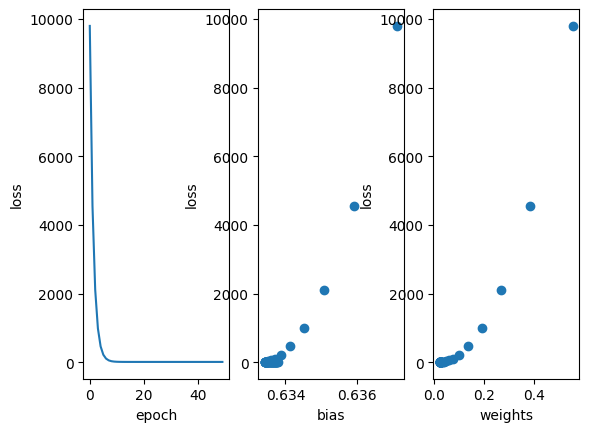

In [7]:
learning_rate = 0.00001
epochs = 50
model = LinearRegressionOwn(learning_rate=learning_rate, epochs=epochs)

weights, bias, losses_list, bias_list, weights_list = model.fit(first_pixel_red_values_train, labels_train)

plotter.subplot(1, 3, 1)
plotter.plot(numpy.arange(len(losses_list)), losses_list)
plotter.xlabel("epoch")
plotter.ylabel("loss")

plotter.subplot(1, 3, 2)
plotter.scatter(bias_list, losses_list)
plotter.xlabel("bias")
plotter.ylabel("loss")

plotter.subplot(1, 3, 3)
plotter.scatter(weights_list, losses_list)
plotter.xlabel("weights")
plotter.ylabel("loss")

Test prediction

In [8]:
own_model_prediction = model.predict(first_pixel_red_values_test)
own_model_errors = get_errors(labels_test, own_model_prediction)

MSE:9.15946834319939 RMSE:3.026461356634079 MAE:2.4698187500256816


### Run with Normal Equation

In [9]:
X_train_with_bias = numpy.c_[numpy.ones((len(first_pixel_red_values_train), 1)), first_pixel_red_values_train]
X_train_with_bias_transposed = X_train_with_bias.T
theta_array = numpy.linalg.inv(X_train_with_bias_transposed.dot(X_train_with_bias)).dot(X_train_with_bias_transposed).dot(labels_train)

X_test_with_bias = numpy.c_[numpy.ones((len(first_pixel_red_values_test),1)), first_pixel_red_values_test]
X_test_with_bias[0:5]

normal_equation_prediction = X_test_with_bias.dot(theta_array)
normal_equation_errors = get_errors(labels_test, normal_equation_prediction)

MSE:7.1727313354287645 RMSE:2.678195537190809 MAE:2.3112987704237615


### Run with SKLEARN

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(first_pixel_red_values_train, labels_train)

sklearn_linear_regression_prediction = model.predict(first_pixel_red_values_test)
sklean_linear_regression_errors = get_errors(labels_test, sklearn_linear_regression_prediction)

MSE:7.1727313354287645 RMSE:2.678195537190809 MAE:2.3112987704237615


# Plot error comparisons between 3 models

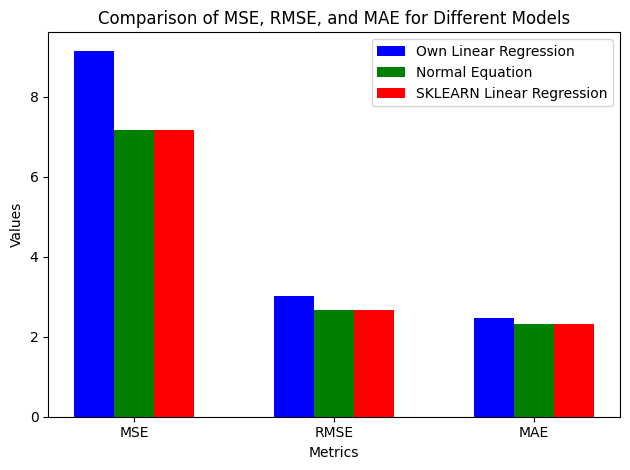

In [11]:
metrics = ['MSE', 'RMSE', 'MAE']
models = ['Own Linear Regression', 'Normal Equation', 'SKLEARN Linear Regression']
colors = ['b', 'g', 'r']

all_errors = numpy.array([
    own_model_errors,
    normal_equation_errors,
    sklean_linear_regression_errors
])

bar_width = 0.2
index = numpy.arange(len(metrics))
fig, ax = plotter.subplots()

bar_positions = [index + i * bar_width for i in range(len(models))]


for i, model_metrics in enumerate(all_errors):
    ax.bar(bar_positions[i], model_metrics, bar_width, color=colors[i], label=models[i])

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of MSE, RMSE, and MAE for Different Models')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics)
ax.legend()

# Show the plot
plotter.tight_layout()
plotter.show()